In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy.fft as fft
from numba import jit
import scipy.stats as stats

# Preliminaries

In [2]:
data_filename = "file_field0.14.csv"
data = pd.read_csv(data_filename, header=None).values

In [3]:
def center(z):
    mask1 = (z==-1).sum(axis=0)
    mask2 = (z==-1).sum(axis=1)
    max1 = mask1.max()
    max2 = mask2.max()
    boundary1 = np.argwhere(mask1 == max1).flatten()
    boundary2 = np.argwhere(mask2==max2).flatten()
    lb1 = np.argmax(np.diff(boundary1))
    lb2 = np.argmax(np.diff(boundary2))
    minb_1, maxb_1 = boundary1[lb1],boundary1[lb1+1] #lateral figure
    minb_2, maxb_2 = boundary2[lb2],boundary2[lb2+1]
    xc = (minb_1+maxb_1)/2
    yc = (minb_2+maxb_2)/2
    radius_x = (maxb_1-minb_1)/2
    radius_y = (maxb_2-minb_2)/2
    return xc,yc,radius_x,radius_y

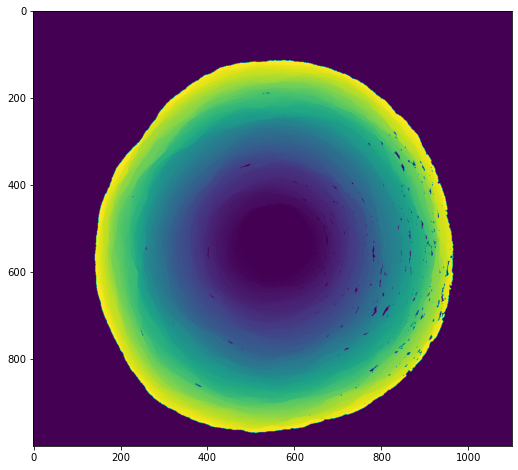

In [4]:
fig, ax = plt.subplots(figsize=(10,8))
plt.imshow(data)
plt.savefig('data.pdf')
plt.show()

In [5]:
xc,yc,radius_x,radius_y = center(data)

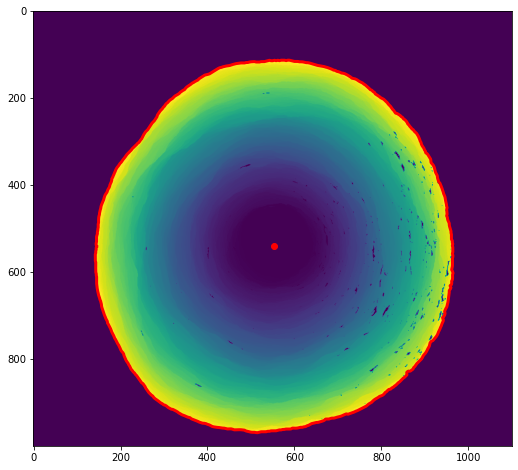

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
plt.imshow(data)
plt.scatter(xc,yc, c='red')
temp = np.linspace(0,np.pi*2)
#plt.plot(np.cos(temp)*radius_x+xc,np.sin(temp)*radius_y+yc,color='red',lw=3,linestyle='dashed')
last_time = list(interface_dict.keys())[-1]
last_radius = interface_dict[last_time]
temp = np.linspace(-np.pi,np.pi,len(last_radius))
plt.plot(np.cos(temp)*last_radius+xc,np.sin(temp)*last_radius+yc,color='red',lw=3)
plt.savefig('data2.pdf')
plt.show()

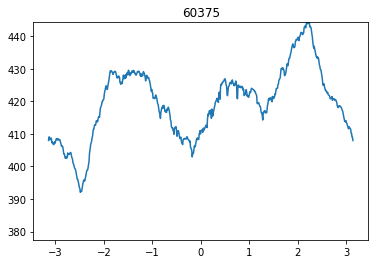

In [11]:
%matplotlib inline
import matplotlib.animation as animation
fig, ax = plt.subplots()
t0 = 55000
tf=list(interface_dict.keys())[-1]
n_frames=tf-t0
n_angles_temp = interface_dict[t0].shape[0]
angle_temp = np.linspace(-np.pi,np.pi,n_angles_temp)
line, = ax.plot(angle_temp, interface_dict[t0])
plt.ylim(interface_dict[t0].min(),interface_dict[tf].max())
def animate(i):
    ax.set_title(t0+i)
    line.set_ydata(interface_dict[t0+i])  # update the data.
    return line,
ani = animation.FuncAnimation(fig, animate, interval=1, frames=n_frames)
ani.save('interface.mp4')
plt.show()

# Velocity

In [7]:
filename = "interface0.14.pkl"
with open(filename, 'rb') as f:
    interface_dict, x_dict, y_dict, t_dict = pickle.load(f)

In [3]:
n_times = len(list(interface_dict.keys()))
interface = np.zeros((n_times, len(interface_dict[0])))
for t, h in interface_dict.items():
    interface[t,:] = h
start_from = np.argwhere((interface==0).sum(axis=1)>0).flatten()[-1]
interface = interface[start_from+1:]

In [77]:
r_mean = np.array([ np.mean(interface_dict[key])  for key in interface_dict])
r_std = np.array([ np.std(interface_dict[key])  for key in interface_dict])

In [81]:
times = np.array(list( interface_dict.keys()))

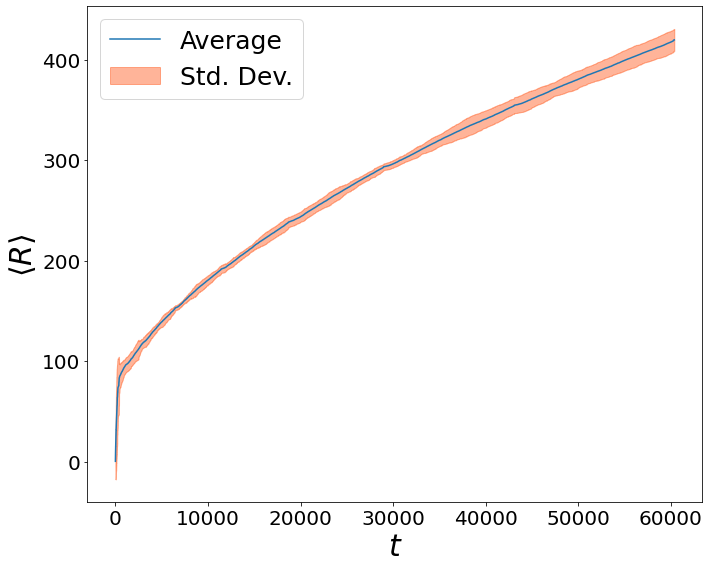

In [105]:
fig,ax = plt.subplots(figsize=(10,8))
plt.plot(times,r_mean,label='Average')
plt.fill_between(times,r_mean-r_std,r_mean+r_std,color='orangered',alpha=0.4,label='Std. Dev.')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$t$', fontsize=30)
plt.ylabel('$\\langle R \\rangle$', fontsize=30)
plt.legend(fontsize=25)
plt.tight_layout()
plt.savefig('rmean.pdf')
plt.show()

In [5]:
def compute_velocity(h):
    V = []
    min_length = h.shape[0]
    for idx in range(h.shape[1]):
        dh = np.diff(h[:,idx])
        jump_times = np.argwhere(dh>0).flatten()
        jumps = dh[jump_times]
        waiting_times = np.diff(np.insert(jump_times,0,0))
        velocities = jumps/(waiting_times+1)
        v = np.repeat(velocities,waiting_times )
        if(len(v)<min_length):
            min_length = len(v)
        V.append(v)
    vel = np.zeros((len(V), min_length))
    for idx in range(len(V)):
        vel[idx,:] = V[idx][:min_length]
    return vel

In [6]:
v_h = compute_velocity(interface)

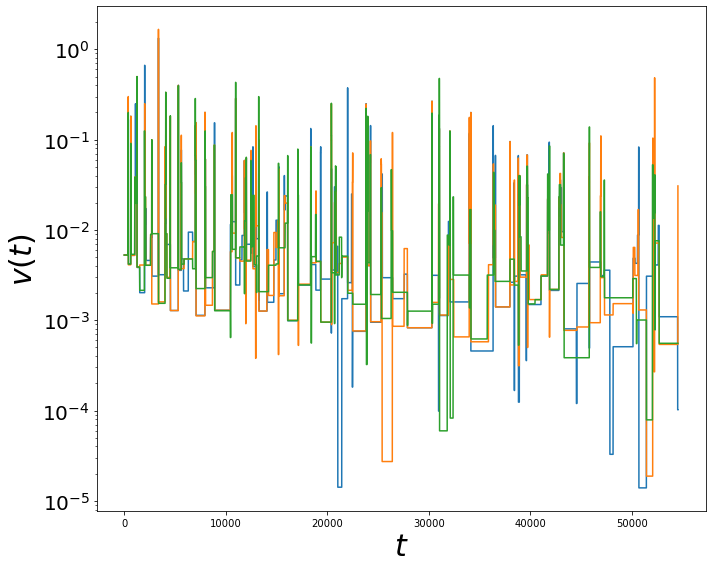

In [171]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(v_h[0,:])
plt.plot(v_h[1,:])
plt.plot(v_h[2,:])
plt.yscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=20)
plt.xlabel('$t$',fontsize=30)
plt.ylabel('$v(t)$',fontsize=30)
plt.tight_layout()
plt.savefig('velocity.pdf')
plt.show()

In [7]:
c_t = fft.ifft(np.abs( fft.fft(v_h-v_h.mean(axis=1).reshape(-1,1), axis=1))**2, axis=1).real.mean(axis=0)
c_t = c_t[:len(c_t)//2]
c_th = fft.ifft(np.abs( fft.fft(v_h-v_h.mean(axis=0), axis=0))**2, axis=0).real.mean(axis=1)
c_th = c_th[:len(c_th)//2]

# Roughness

In [16]:
def interface_flucts(h, dtheta,window_max=-1):
    if(window_max==-1):
        window_max = h.shape[1]
    W = np.zeros((h.shape[0], window_max-1))
    L = np.zeros((h.shape[0], window_max-1))
    print('First trasform...')
    h_k = fft.fft(h, axis=1)
    print('Second transform...')
    h_sq_k = fft.fft(h**2, axis=1)
    f_ks = np.zeros((window_max-1,h.shape[1]))
    for window in range(2,window_max+1):
        f_ks[window-2,:window] = 1/window
    f_ks = fft.fft(f_ks, axis=1)

    for t in range(0,h.shape[0]):
        if(t % 1000 == 0):
            print('Step: ', t)
        for window in range(10,window_max+1):            
            avg_h = fft.ifft(h_k[t,:]*f_ks[window-2,:]).real
            var_h = fft.ifft(h_sq_k[t,:]*f_ks[window-2,:]).real-avg_h**2
            W[t,window-2] = var_h.mean()
            L[t,window-2] = avg_h.mean()*window*dtheta
    return W,L

In [21]:
W,L = interface_flucts(interface, 2*np.pi/interface.shape[1])

First trasform...
Second transform...
Step:  0
Step:  1000
Step:  2000
Step:  3000
Step:  4000
Step:  5000
Step:  6000
Step:  7000
Step:  8000
Step:  9000
Step:  10000
Step:  11000
Step:  12000
Step:  13000
Step:  14000
Step:  15000
Step:  16000
Step:  17000
Step:  18000
Step:  19000
Step:  20000
Step:  21000
Step:  22000
Step:  23000
Step:  24000
Step:  25000
Step:  26000
Step:  27000
Step:  28000
Step:  29000
Step:  30000
Step:  31000
Step:  32000
Step:  33000
Step:  34000
Step:  35000
Step:  36000
Step:  37000
Step:  38000
Step:  39000
Step:  40000
Step:  41000
Step:  42000
Step:  43000
Step:  44000
Step:  45000
Step:  46000
Step:  47000
Step:  48000
Step:  49000
Step:  50000
Step:  51000
Step:  52000
Step:  53000
Step:  54000
Step:  55000
Step:  56000
Step:  57000


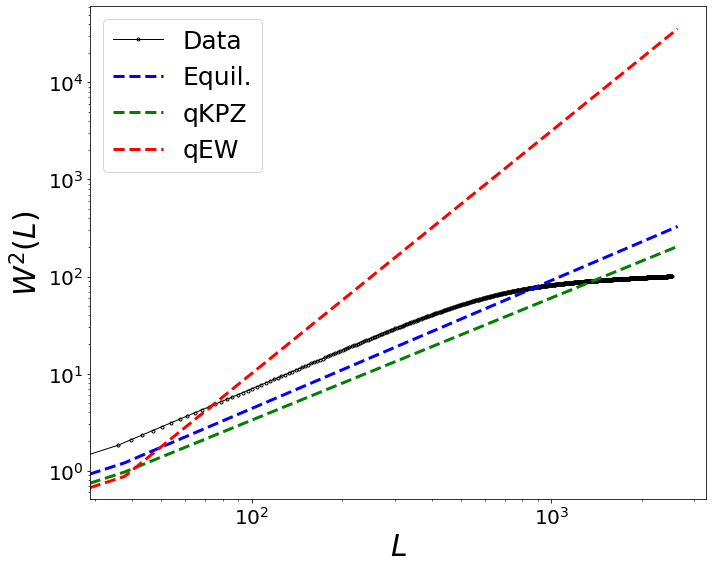

In [122]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(L[-10000:].mean(axis=0),W[-10000:].mean(axis=0), color='black',marker='.',lw=1, markerfacecolor='none', label='Data')
plt.plot(L[-1],0.01*L[-1]**1.32, color='blue', label='Equil.',lw=3,linestyle='dashed')
plt.plot(L[-1],0.01*L[-1]**1.26, color='green',label='qKPZ',lw=3,linestyle='dashed')
plt.plot(L[-1],0.0001*L[-1]**2.50, color='red',label='qEW',lw=3,linestyle='dashed')
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.yscale('log')
plt.xlabel('$L$', fontsize=30)
plt.ylabel('$W^2(L)$', fontsize=30)
plt.legend(fontsize=25)
plt.tight_layout()
plt.savefig('w2.pdf')
plt.show()